# Data Exploration and Feature Grouping

In this notebook we do some quick cleaning of the dataset and perform LDA with features grouped according to correlation.  

In [1]:
# import libraries needed

import pandas as pd
import numpy as np
from pennylane import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane_qiskit import IBMQDevice
from pennylane_qiskit import BasicAerDevice
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# visualization

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
start = time.time()

## Clean-up and Quick Run

In [2]:
# Read out CSV and sets/samples creation

df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')
df = df.astype(float)
df = df.drop(['Unnamed: 0'], axis = 1)
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,20468.0,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,3.226256,0.0,0.0,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,20.564308,0.0,0.0,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.0,0.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,2301.000000,0.0,0.0,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


Some columns seem to be all zeros. Let's drop them as they provide no differentiation between observations.

In [3]:
df_clean = df.loc[:, df.any()]
df_clean.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_13,col_14,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,3.226256,0.038646,0.363152,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,20.564308,0.192754,0.480920,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,2301.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


Note: `col_7` is an exact copy of `col_0`. We will drop it.

In [4]:
df_clean = df_clean.drop('col_7', axis = 1)

In [5]:
# save the cleaned data

df_clean.to_csv("dataset_cleaned.csv")

Now let's go through the whole process by simply spliting the features evenly into two groups.

In [6]:
df_sample = df_clean.sample(2000)
train,test = train_test_split(df_sample, test_size=0.30, random_state=10)
train_set = train
test_set = test
np.random.seed(42)

In [7]:
# Separation of labels

y_train = train_set[['targets']]
x_train = train_set.drop('targets', axis=1)


y_test = test_set[['targets']]
x_test = test_set.drop('targets', axis=1)

In [8]:
# grouping features
split_point = x_train.columns[len(x_train.columns)//2]

features_a = x_train.loc[:,:split_point]
features_b = x_train.loc[:,split_point:]

features_a_test = x_test.loc[:,:split_point]
features_b_test = x_test.loc[:,split_point:]
features_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 16246 to 5393
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col_0   1400 non-null   float64
 1   col_1   1400 non-null   float64
 2   col_2   1400 non-null   float64
 3   col_3   1400 non-null   float64
 4   col_4   1400 non-null   float64
 5   col_5   1400 non-null   float64
 6   col_6   1400 non-null   float64
 7   col_13  1400 non-null   float64
 8   col_14  1400 non-null   float64
 9   col_15  1400 non-null   float64
 10  col_16  1400 non-null   float64
 11  col_17  1400 non-null   float64
 12  col_22  1400 non-null   float64
 13  col_23  1400 non-null   float64
 14  col_24  1400 non-null   float64
 15  col_25  1400 non-null   float64
 16  col_26  1400 non-null   float64
 17  col_27  1400 non-null   float64
 18  col_28  1400 non-null   float64
 19  col_29  1400 non-null   float64
 20  col_30  1400 non-null   float64
 21  col_31  1400 non-null   float64
 

### LDA Features

In [9]:
# transform the features

lda = LDA(n_components=1)
features_lda_1 = lda.fit_transform(features_a, y_train.values.ravel())
features_lda_1_test = lda.transform(features_a_test)

features_lda_2 = lda.fit_transform(features_b, y_train.values.ravel())
features_lda_2_test = lda.transform(features_b_test)

In [10]:
features_lda_1 = pd.DataFrame(features_lda_1)
features_lda_2 = pd.DataFrame(features_lda_2)

features_lda_1_test = pd.DataFrame(features_lda_1_test)
features_lda_2_test = pd.DataFrame(features_lda_2_test)

In [11]:
features_lda_1.head()

,0
0,-1.647234
1,-0.315169
2,-1.624434
3,0.647323
4,-0.890059


In [12]:
# combine the 2 features

x_train_lda = features_lda_1.join(features_lda_2, lsuffix="_left", rsuffix="_right")
x_test_lda = features_lda_1_test.join(features_lda_2_test, lsuffix="_left", rsuffix="_right")

In [13]:
x_train_lda

,0_left,0_right
0,-1.647234,-1.062756
1,-0.315169,-0.704260
2,-1.624434,-0.486132
3,0.647323,-0.111503
4,-0.890059,-0.912891
...,...,...
1395,-0.865866,-0.531186
1396,0.207545,-0.111503
1397,0.955061,3.510328
1398,0.683500,0.411537


In [14]:
x_test_lda

,0_left,0_right
0,0.979135,0.411537
1,0.429368,1.964625
2,-0.920524,-1.649966
3,1.350660,-0.111503
4,0.593554,0.604855
...,...,...
595,0.811924,-0.524621
596,-0.283575,-0.893253
597,0.790146,1.775425
598,-1.128501,-0.131876


In [15]:
# Normalize

std_scale = StandardScaler().fit(x_train_lda)
data = std_scale.transform(x_train_lda)

std_scale = StandardScaler().fit(x_test_lda)
x_test_lda_n = std_scale.transform(x_test_lda)

In [16]:
x_test_lda_n

array([[ 0.76170468,  0.31532716],
       [ 0.31445428,  1.48863532],
       [-0.78372021, -1.24207227],
       ...,
       [ 0.60795684,  1.34570102],
       [-0.95291501, -0.0952042 ],
       [ 0.41876601, -0.57448618]])

In [17]:
n_dim = 2

In [18]:
# Review the balance of the target variable in train

y_train.value_counts(normalize=True)*100

targets
0.0        73.142857
1.0        26.857143
dtype: float64

In [19]:
# Review the balance of the target variable in test

y_test.value_counts(normalize=True)*100

targets
0.0        71.833333
1.0        28.166667
dtype: float64

### QML

We then perform quantum machine learning using the two LDA features.

In [20]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits, shots=1024)
#dev = qml.device('default.qubit.tf', wires = num_qubits, shots=1024)
#dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_manila', ibmqx_token="6cc75c58fc80fea56cb8dd391f8fbcfdb676a3dc7005493728bc9da7ea753e31a2110a01e3a0cc83f1a98f5ca79e32956fc66c11b5eea4cae163b3fa996be356", shots=256)
#dev = qml.device('qiskit.basicaer', wires = num_qubits, shots = 256)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [21]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[ 0.00496714 -0.00138264  0.00647689]
  [ 0.0152303  -0.00234153 -0.00234137]]

 [[ 0.01579213  0.00767435 -0.00469474]
  [ 0.0054256  -0.00463418 -0.0046573 ]]

 [[ 0.00241962 -0.0191328  -0.01724918]
  [-0.00562288 -0.01012831  0.00314247]]

 [[-0.00908024 -0.01412304  0.01465649]
  [-0.00225776  0.00067528 -0.01424748]]

 [[-0.00544383  0.00110923 -0.01150994]
  [ 0.00375698 -0.00600639 -0.00291694]]] 0.0


In [22]:
circuit(weights_init, data[0])

tensor(0.70507812, requires_grad=True)

In [23]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [24]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [25]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [26]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [27]:
Y = np.array(y_train.values[:,0] * 2 - np.ones(len(y_train.values[:,0])), requires_grad = False)  # shift label from {0, 1} to {-1, 1}
X = np.array(data, requires_grad=False)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-1.5025838, requires_grad=False), tensor(-0.79914964, requires_grad=False)], Y = -1
X = [tensor(-0.28749305, requires_grad=False), tensor(-0.52957516, requires_grad=False)], Y = -1
X = [tensor(-1.48178608, requires_grad=False), tensor(-0.36555189, requires_grad=False)], Y = -1
X = [tensor(0.59047896, requires_grad=False), tensor(-0.08384601, requires_grad=False)], Y = -1
X = [tensor(-0.81189893, requires_grad=False), tensor(-0.686457, requires_grad=False)], Y = -1


In [28]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [29]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(50):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

New best
Iter:     1 | Cost: 0.7757074 | Accuracy: 0.7328571 
New best
Iter:     2 | Cost: 0.6310626 | Accuracy: 0.7764286 
New best
Iter:     3 | Cost: 0.5791569 | Accuracy: 0.7942857 
New best
Iter:     4 | Cost: 0.5505772 | Accuracy: 0.8100000 
New best
Iter:     5 | Cost: 0.5335625 | Accuracy: 0.8121429 
New best
Iter:     6 | Cost: 0.5129484 | Accuracy: 0.8178571 
New best
Iter:     7 | Cost: 0.5097865 | Accuracy: 0.8264286 
New best
Iter:     8 | Cost: 0.5102069 | Accuracy: 0.8307143 
Iter:     9 | Cost: 0.4956267 | Accuracy: 0.8292857 
New best
Iter:    10 | Cost: 0.4752182 | Accuracy: 0.8371429 
Iter:    11 | Cost: 0.5085655 | Accuracy: 0.8300000 
Iter:    12 | Cost: 0.5449851 | Accuracy: 0.8092857 
Iter:    13 | Cost: 0.4992988 | Accuracy: 0.8292857 
New best
Iter:    14 | Cost: 0.4698252 | Accuracy: 0.8421429 
New best
Iter:    15 | Cost: 0.4603315 | Accuracy: 0.8457143 
Iter:    16 | Cost: 0.4665378 | Accuracy: 0.8435714 
Iter:    17 | Cost: 0.4925975 | Accuracy: 0.8371429 


In [30]:
Yte = np.array(y_test.values[:,0] * 2 - np.ones(len(y_test.values[:,0])), requires_grad = False)
Xte = np.array(normalize(x_test_lda_n), requires_grad=False)

In [31]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.5805768328807487, Accuracy: 82.0%


In [32]:
pd.DataFrame((predictions, Yte), ('Predictions', 'Test')).T

,Predictions,Test
0,1.0,1.0
1,1.0,1.0
2,-1.0,-1.0
3,1.0,1.0
4,1.0,-1.0
...,...,...
595,-1.0,-1.0
596,-1.0,-1.0
597,1.0,1.0
598,-1.0,1.0


In [33]:
# Print the classification report and important metrics

print(metrics.classification_report(predictions,Yte))
print(f"precisioin score: {metrics.precision_score(predictions,Yte)}")
print(f"recall score: {metrics.recall_score(predictions,Yte)}")
print(f"f1 score: {metrics.f1_score(predictions,Yte)}")
print(f"balanced accuracy: {metrics.balanced_accuracy_score(predictions,Yte)}")
print(f"confusion matrix: {metrics.confusion_matrix(predictions,Yte)}")

              precision    recall  f1-score   support

        -1.0       0.87      0.87      0.87       432
         1.0       0.67      0.68      0.68       168

    accuracy                           0.82       600
   macro avg       0.77      0.78      0.78       600
weighted avg       0.82      0.82      0.82       600

precisioin score: 0.6745562130177515
recall score: 0.6785714285714286
f1 score: 0.6765578635014836
balanced accuracy: 0.775628306878307
confusion matrix: [[377  55]
 [ 54 114]]


## Feature Grouping

We want to split the features into groups that are similar within but distinct between groups. Let's take a look at the correlation matrix.

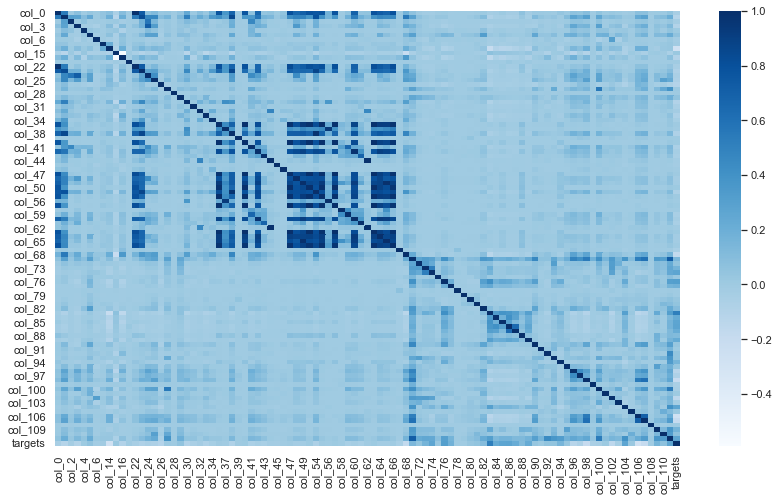

In [34]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_clean.corr()
heatmap = sns.heatmap(corr, annot=False, cmap="Blues", fmt='.1g')

Some columns show a much stronger correlation than others. Let's see if we could group the more strongly correlated ones together. This is probably not optimized but it is a test of idea.

In [35]:
ordered = df_clean[corr['col_0'].sort_values(ascending=False).index]
ordered.head()

,col_0,col_22,col_47,col_66,col_63,col_57,col_50,col_36,col_55,col_40,...,col_104,col_74,col_73,col_84,col_87,col_89,col_86,col_83,targets,col_15
0,9.0,9.0,36.0,32.0,32.0,11.0,15.0,97.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,13.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,17.0,23.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,21.0,34.0,20.0,36.0,36.0,52.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


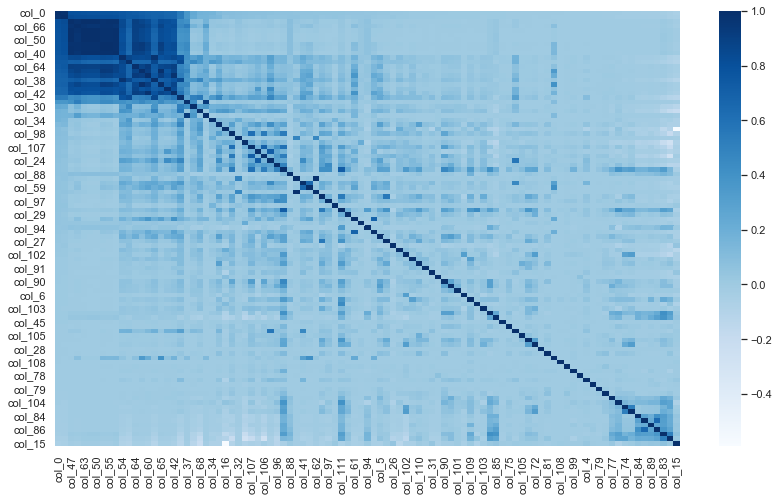

In [36]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr_ordered = ordered.corr()
heatmap = sns.heatmap(corr_ordered, annot=False, cmap="Blues", fmt='.1g')

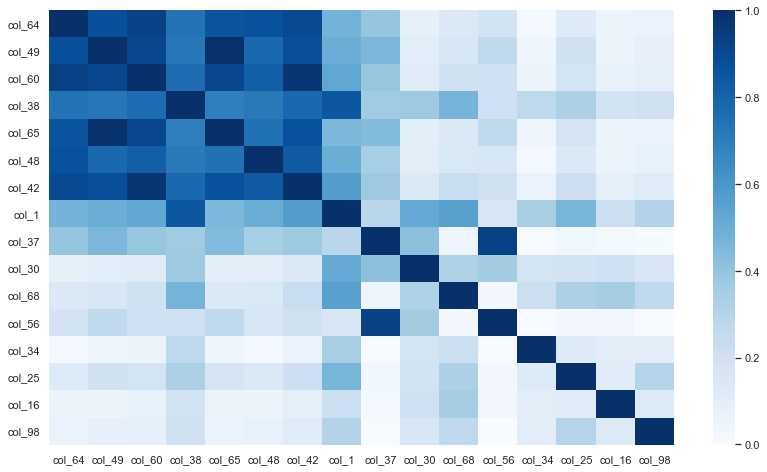

In [37]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr2 = ordered.loc[:,'col_64':'col_98'].corr()
heatmap = sns.heatmap(corr2, annot=False, cmap="Blues", fmt='.1g')

We will pick `col_37`/`col_30` as our splitting point for the two groups. This results in an uneven split (21,75). We perform the LDA and QML on the same sample.

In [38]:
ordred_sample = df_sample[corr['col_0'].sort_values(ascending=False).index]
train,test = train_test_split(ordred_sample, test_size=0.30, random_state=10)
train_set = train
test_set = test
np.random.seed(42)

In [39]:
ordred_sample.head(10)

,col_0,col_22,col_47,col_66,col_63,col_57,col_50,col_36,col_55,col_40,...,col_104,col_74,col_73,col_84,col_87,col_89,col_86,col_83,targets,col_15
2709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14827,0.0,0.0,2.0,3.0,2.0,1.0,1.0,4.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6081,1.0,1.0,35.0,0.0,0.0,0.0,27.0,32.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [40]:
# Separation of labels

y_train = train_set[['targets']]
x_train = train_set.drop('targets', axis=1)


y_test = test_set[['targets']]
x_test = test_set.drop('targets', axis=1)

In [41]:
# grouping features

features_a = x_train.loc[:,:'col_37']
features_b = x_train.loc[:,'col_30':]

features_a_test = x_test.loc[:,:'col_37']
features_b_test = x_test.loc[:,'col_30':]
features_a.shape, features_b.shape

((1400, 21), (1400, 75))

In [42]:
features_a.columns

Index(['col_0', 'col_22', 'col_47', 'col_66', 'col_63', 'col_57', 'col_50',
       'col_36', 'col_55', 'col_40', 'col_54', 'col_23', 'col_64', 'col_49',
       'col_60', 'col_38', 'col_65', 'col_48', 'col_42', 'col_1', 'col_37'],
      dtype='object')

### LDA Features

In [43]:
# transform the features

lda = LDA(n_components=1)
features_lda_1 = lda.fit_transform(features_a, y_train.values.ravel())
features_lda_1_test = lda.transform(features_a_test)

features_lda_2 = lda.fit_transform(features_b, y_train.values.ravel())
features_lda_2_test = lda.transform(features_b_test)

In [44]:
features_lda_1 = pd.DataFrame(features_lda_1)
features_lda_2 = pd.DataFrame(features_lda_2)

features_lda_1_test = pd.DataFrame(features_lda_1_test)
features_lda_2_test = pd.DataFrame(features_lda_2_test)

In [45]:
features_lda_1.head()

,0
0,-0.337612
1,0.424144
2,-1.260492
3,0.454699
4,-0.008053


In [46]:
# combine the 2 features

x_train_lda = features_lda_1.join(features_lda_2, lsuffix="_left", rsuffix="_right")
x_test_lda = features_lda_1_test.join(features_lda_2_test, lsuffix="_left", rsuffix="_right")

In [47]:
x_train_lda

,0_left,0_right
0,-0.337612,-1.688559
1,0.424144,-0.779975
2,-1.260492,-1.135964
3,0.454699,-0.091676
4,-0.008053,-1.018340
...,...,...
1395,0.369068,-0.727799
1396,0.414402,0.031835
1397,0.431892,3.308423
1398,0.449680,0.387571


In [48]:
x_test_lda

,0_left,0_right
0,0.450640,0.926243
1,0.482912,1.736359
2,-0.878407,-1.201244
3,0.450493,0.578571
4,-0.162323,0.700400
...,...,...
595,0.390797,-0.101607
596,0.400229,-1.225276
597,0.439348,1.836483
598,0.343268,-0.491754


In [49]:
# Normalize

std_scale = StandardScaler().fit(x_train_lda)
data = std_scale.transform(x_train_lda)

std_scale = StandardScaler().fit(x_test_lda)
x_test_lda_n = std_scale.transform(x_test_lda)

In [50]:
x_test_lda_n

array([[ 0.34175609,  0.66880864],
       [ 0.36658269,  1.26556677],
       [-0.68066633, -0.89836773],
       ...,
       [ 0.33306869,  1.33932162],
       [ 0.25915566, -0.37573438],
       [ 0.34141525, -0.38111563]])

In [51]:
n_dim = 2

In [52]:
# Review the balance of the target variable in train

y_train.value_counts(normalize=True)*100

targets
0.0        73.142857
1.0        26.857143
dtype: float64

In [53]:
# Review the balance of the target variable in test

y_test.value_counts(normalize=True)*100

targets
0.0        71.833333
1.0        28.166667
dtype: float64

### QML

We then perform quantum machine learning using the two LDA features.

In [54]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits, shots=1024)
#dev = qml.device('default.qubit.tf', wires = num_qubits, shots=1024)
#dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_manila', ibmqx_token="6cc75c58fc80fea56cb8dd391f8fbcfdb676a3dc7005493728bc9da7ea753e31a2110a01e3a0cc83f1a98f5ca79e32956fc66c11b5eea4cae163b3fa996be356", shots=256)
#dev = qml.device('qiskit.basicaer', wires = num_qubits, shots = 256)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [55]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[ 0.00496714 -0.00138264  0.00647689]
  [ 0.0152303  -0.00234153 -0.00234137]]

 [[ 0.01579213  0.00767435 -0.00469474]
  [ 0.0054256  -0.00463418 -0.0046573 ]]

 [[ 0.00241962 -0.0191328  -0.01724918]
  [-0.00562288 -0.01012831  0.00314247]]

 [[-0.00908024 -0.01412304  0.01465649]
  [-0.00225776  0.00067528 -0.01424748]]

 [[-0.00544383  0.00110923 -0.01150994]
  [ 0.00375698 -0.00600639 -0.00291694]]] 0.0


In [56]:
circuit(weights_init, data[0])

tensor(0.35351562, requires_grad=True)

In [57]:
Y = np.array(y_train.values[:,0] * 2 - np.ones(len(y_train.values[:,0])), requires_grad = False)  # shift label from {0, 1} to {-1, 1}
X = np.array(data, requires_grad=False)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.33232882, requires_grad=False), tensor(-1.23501011, requires_grad=False)], Y = -1
X = [tensor(0.41750687, requires_grad=False), tensor(-0.57047307, requires_grad=False)], Y = -1
X = [tensor(-1.24076777, requires_grad=False), tensor(-0.83084238, requires_grad=False)], Y = -1
X = [tensor(0.44758408, requires_grad=False), tensor(-0.06705202, requires_grad=False)], Y = -1
X = [tensor(-0.00792708, requires_grad=False), tensor(-0.74481253, requires_grad=False)], Y = -1


In [58]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [59]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(50):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

New best
Iter:     1 | Cost: 0.6840120 | Accuracy: 0.7707143 
New best
Iter:     2 | Cost: 0.6884128 | Accuracy: 0.7721429 
New best
Iter:     3 | Cost: 0.6497199 | Accuracy: 0.7907143 
New best
Iter:     4 | Cost: 0.5526323 | Accuracy: 0.8092857 
New best
Iter:     5 | Cost: 0.5106892 | Accuracy: 0.8278571 
New best
Iter:     6 | Cost: 0.4907973 | Accuracy: 0.8342857 
New best
Iter:     7 | Cost: 0.4633183 | Accuracy: 0.8385714 
New best
Iter:     8 | Cost: 0.4659939 | Accuracy: 0.8400000 
New best
Iter:     9 | Cost: 0.4767518 | Accuracy: 0.8442857 
New best
Iter:    10 | Cost: 0.4574803 | Accuracy: 0.8492857 
Iter:    11 | Cost: 0.4465304 | Accuracy: 0.8492857 
Iter:    12 | Cost: 0.5129355 | Accuracy: 0.8428571 
New best
Iter:    13 | Cost: 0.4968205 | Accuracy: 0.8507143 
New best
Iter:    14 | Cost: 0.4471275 | Accuracy: 0.8550000 
Iter:    15 | Cost: 0.4336792 | Accuracy: 0.8528571 
New best
Iter:    16 | Cost: 0.4278970 | Accuracy: 0.8578571 
Iter:    17 | Cost: 0.4443043 | Acc

In [60]:
Yte = np.array(y_test.values[:,0] * 2 - np.ones(len(y_test.values[:,0])), requires_grad = False)
Xte = np.array(normalize(x_test_lda_n), requires_grad=False)

In [61]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.47292335627528304, Accuracy: 84.0%


In [62]:
pd.DataFrame((predictions, Yte), ('Predictions', 'Test')).T

,Predictions,Test
0,1.0,1.0
1,1.0,1.0
2,-1.0,-1.0
3,1.0,1.0
4,1.0,-1.0
...,...,...
595,-1.0,-1.0
596,-1.0,-1.0
597,1.0,1.0
598,-1.0,1.0


In [63]:
# Print the classification report and important metrics

print(metrics.classification_report(predictions,Yte))
print(f"precisioin score: {metrics.precision_score(predictions,Yte)}")
print(f"recall score: {metrics.recall_score(predictions,Yte)}")
print(f"f1 score: {metrics.f1_score(predictions,Yte)}")
print(f"balanced accuracy: {metrics.balanced_accuracy_score(predictions,Yte)}")
print(f"confusion matrix: {metrics.confusion_matrix(predictions,Yte)}")

              precision    recall  f1-score   support

        -1.0       0.91      0.86      0.89       456
         1.0       0.63      0.74      0.68       144

    accuracy                           0.83       600
   macro avg       0.77      0.80      0.79       600
weighted avg       0.85      0.83      0.84       600

precisioin score: 0.6331360946745562
recall score: 0.7430555555555556
f1 score: 0.6837060702875398
balanced accuracy: 0.8035453216374269
confusion matrix: [[394  62]
 [ 37 107]]


It performs better than a half & half split overall.